# Evaluating Customer Spending Score Predictions From Linear Regression, Support Vector Regression, and Random Forest Regression Models

#### coded by: K.M. Anderson

## Overview

- Customer Spending Data
- Supervised Continuous Task
- Predicting a Spending Score on a scale from 1 to 100
- Comparison of:
    - Linear Regression Model
    - Support Vector Regression (SVR) & SVR with Hyperparameter Optimisation Model
    - Random Forest Regression Model

## Exploring Data with Various Libraries

Importing all necessary libraries including:
- pandas
- NumPy
- Matplotlib
- Seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR 
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore', category=UserWarning)


%matplotlib inline

In [ ]:
df = pd.read_csv('customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## Data Analysis

Exploring the size, variety, and information of the data to get a general idea of the data. This was done by observing the columns, variable types, shape, and counts of the features. The primary utilisation method was Pandas and NumPy. 

In [ ]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size'],
      dtype='object')

In [ ]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


### Categorical Data Analysis 

In [ ]:
print('CustomerID has {} different values so it is best to drop it'
      .format(len(df['CustomerID'].unique())))
df = df.drop(['CustomerID'], axis=1)

CustomerID has 2000 different values so it is best to drop it


In [ ]:
print('Values and counts for Profession are:\n{}'.format(df['Profession'].value_counts()))
print('Values and normalised counts for Profession are:\n{}'.format(df['Profession'].value_counts(normalize=True)))


Values and counts for Profession are:
Artist           612
Healthcare       339
Entertainment    234
Engineer         179
Doctor           161
Executive        153
Lawyer           142
Marketing         85
Homemaker         60
Name: Profession, dtype: int64
Values and normalised counts for Profession are:
Artist           0.311450
Healthcare       0.172519
Entertainment    0.119084
Engineer         0.091094
Doctor           0.081934
Executive        0.077863
Lawyer           0.072265
Marketing        0.043257
Homemaker        0.030534
Name: Profession, dtype: float64


Wanted to visualise the list of professions to confirm that there only 9 professions were included in the data.

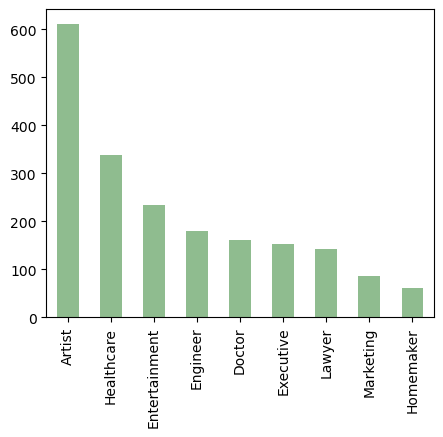

In [ ]:
df['Profession'].value_counts().plot.bar(figsize=(5, 4), color='darkseagreen') 
plt.show()

These figures also demonstrates a good overview on the features 'Gender' and 'Family size'. 

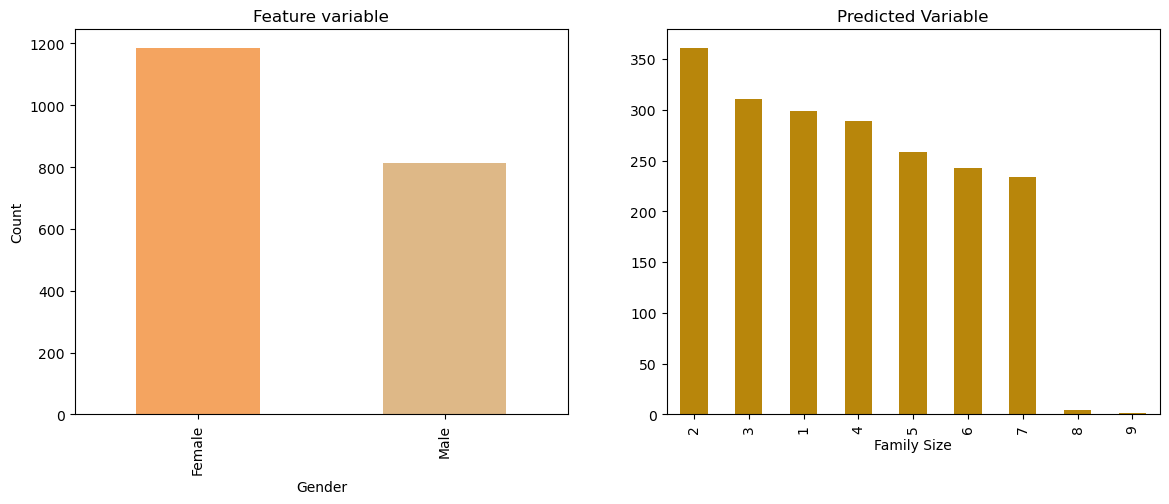

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
df['Gender'].value_counts().plot(ax=axes[0], kind='bar',
                                title='Feature variable', color=['sandybrown', 'burlywood'],
                                ylabel = 'Count', xlabel='Gender')
df['Family Size'].value_counts().plot(ax=axes[1], kind='bar',
                                      title='Predicted Variable', xlabel='Family Size', color=['darkgoldenrod']) 
plt.show()

Taking a look at other variables and their relations to each other...

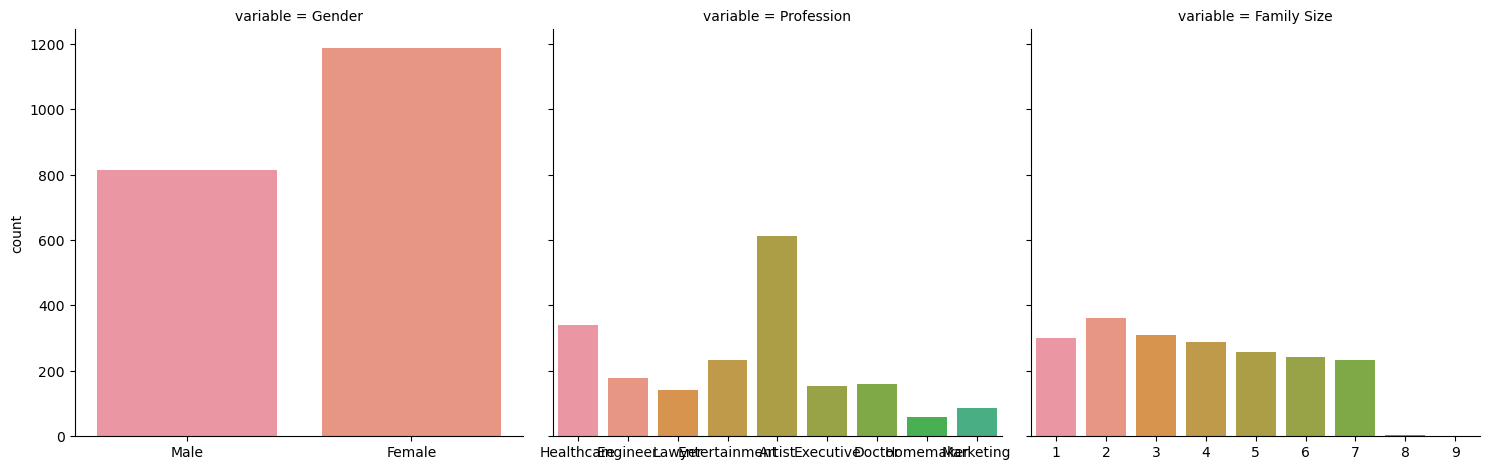

In [ ]:
data = pd.melt(df[['Gender', 'Profession', 'Family Size']])
g = sns.catplot(data=data, kind='count', col='variable', x='value', y=None, sharex=False)
g.set_axis_labels(x_var='')
plt.show()

### Continous Data Analysis 

- It appears that counts for annual income spike at around 60,000 for the histogram
    - this infers that 60,000 may be a common annual income for customers in this dataset
- Counts for the annual income spike at what appears to be a little less than half so maybe 40,000-45,000 for the density plot
    - this demonstrates that there is a wide range of incomes and that there is a relatively flat distribution across the higher income values
- Counts for annual income demonstrate the lower quartile to be 75,000 and upper quartile 150,000 for the boxplot
    - this shows the lower and higher income outliers that fit outside the 75,000 and 150,000 quartile range

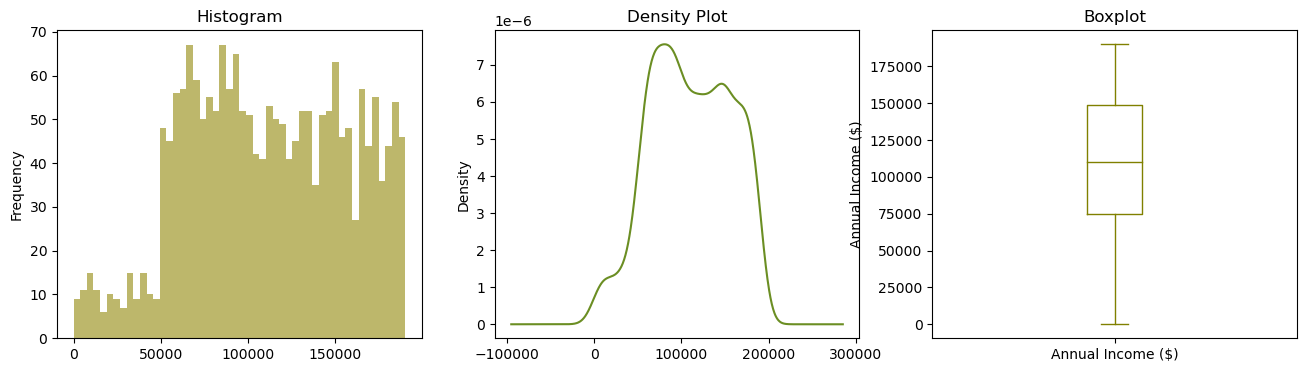

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
df['Annual Income ($)'].plot(kind='hist', color='darkkhaki',bins=50, ax=axes[0], xlabel="Annual Income ($)",
                           title="Histogram")
df['Annual Income ($)'].plot(kind='density', color='olivedrab', ax=axes[1], title='Density Plot')
df['Annual Income ($)'].plot(kind='box', ax=axes[2], ylabel='Annual Income ($)',
                           xlabel='', title='Boxplot', color='olive')
plt.show()

### Bivariate Analysis

Demonstrating the difference between female and male customers for family size in the first graph and work experience in the second.

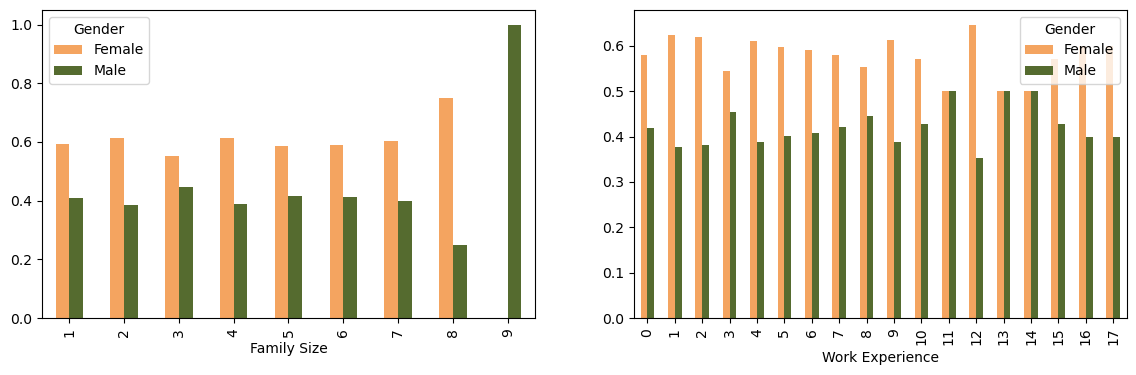

In [ ]:
FamilySize = pd.crosstab(df['Family Size'],df['Gender'])
FamilySize = FamilySize.div(FamilySize.sum(1).astype(float), axis=0)

WE = pd.crosstab(df['Work Experience'],df['Gender'])
WE = WE.div(WE.sum(1).astype(float), axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
FamilySize.plot(kind="bar", ax=axes[0], color=['sandybrown', 'darkolivegreen'])
WE.plot(kind="bar", ax=axes[1], color=['sandybrown', 'darkolivegreen'])
plt.show()

Another comparison of male and female customers for each age bin that is divided into 5 groups:
- under 25
- 25-34
- 35-44
- 45-54
- 55 and above

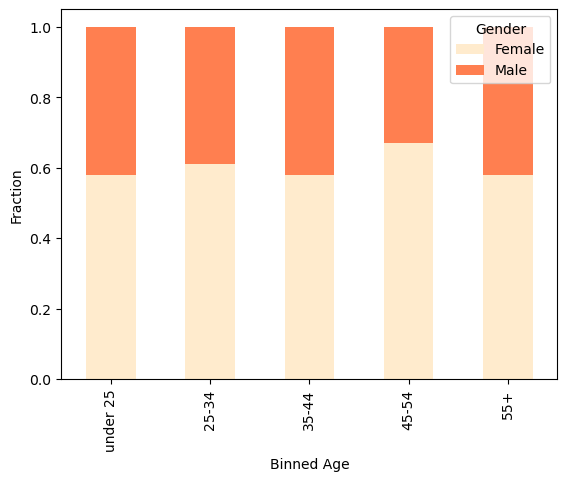

In [ ]:
bins=[0,25,34,45,55,100]
labels=['under 25','25-34','35-44','45-54', '55+']
df['Age_Bin']=pd.cut(df['Age'],bins,labels=labels)

Age_Bin=pd.crosstab(df['Age_Bin'],df['Gender'])
Age_Bin = Age_Bin.div(Age_Bin.sum(1).astype(float), axis=0)
Age_Bin.plot(kind="bar",stacked=True, xlabel="Binned Age", ylabel="Fraction", color=['blanchedalmond','coral'])

plt.show()

## Cleaning Data  

df.isnull().sum shows all added missing values of each feature

In [ ]:
df.isnull().sum()

Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
Age_Bin                   24
dtype: int64

In [ ]:
df['Profession'] = df["Profession"].fillna(df['Profession'].mode()[0])
df['Age_Bin'] = df["Age_Bin"].fillna(df['Age_Bin'].mode()[0])

In [ ]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income ($)         0
Spending Score (1-100)    0
Profession                0
Work Experience           0
Family Size               0
Age_Bin                   0
dtype: int64

### Convert Features to Integers 

Before:

In [ ]:
df.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Age_Bin
0,Male,19,15000,39,Healthcare,1,4,under 25
1,Male,21,35000,81,Engineer,3,3,under 25
2,Female,20,86000,6,Engineer,1,1,under 25
3,Female,23,59000,77,Lawyer,0,2,under 25
4,Female,31,38000,40,Entertainment,2,6,25-34


After:

In [ ]:
df['Gender'] = df['Gender'].astype('category').cat.codes
df['Profession'] = df['Profession'].astype('category').cat.codes
df['Age_Bin'] = df['Age_Bin'].astype('category').cat.codes

df.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Age_Bin
0,1,19,15000,39,5,1,4,0
1,1,21,35000,81,2,3,3,0
2,0,20,86000,6,2,1,1,0
3,0,23,59000,77,7,0,2,0
4,0,31,38000,40,3,2,6,1


### Samples 

Lastly, I'm adding a smaller samples just in case my dataset becomes too crowded in the visualisers.

In [ ]:
sample100 = df.sample(100, random_state=44)

## Correlations

### Heatmap using Seaborn

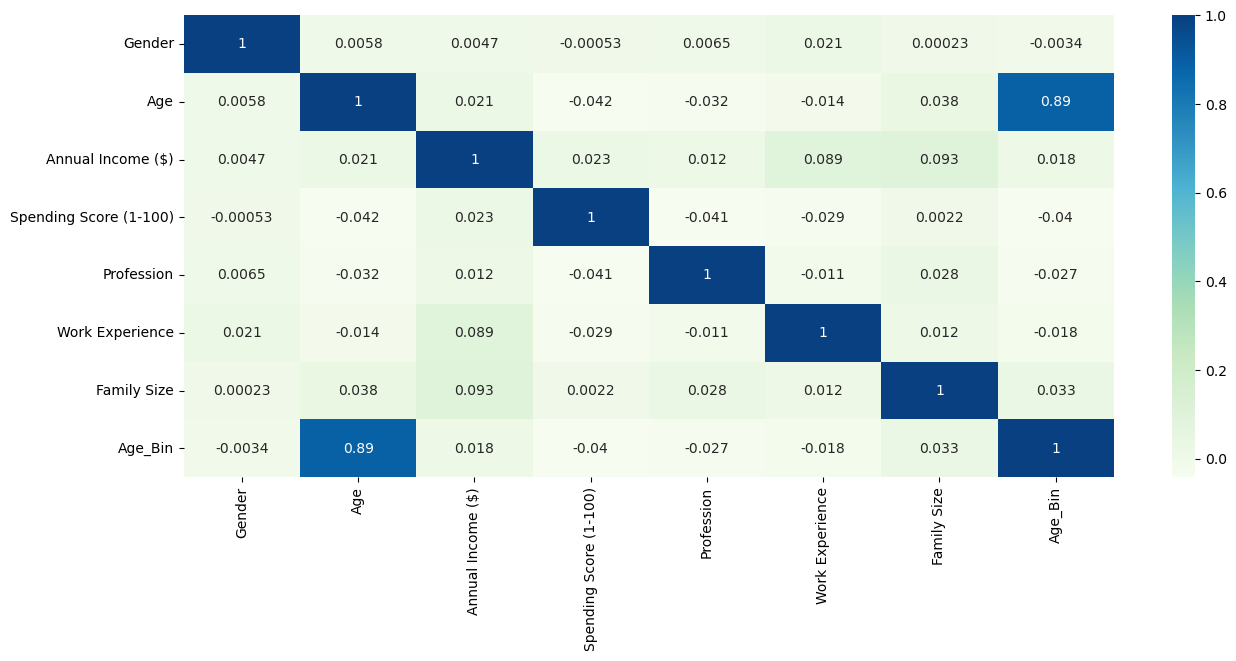

In [ ]:
corr=df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="GnBu")
plt.show()

I thought Age_Bin would be a better way of clustering ages to visualise my data but after doing so, I realized it just makes my data messier than it needed to be. Also since Age and Age_Bin have such a high correlation, I decided to drop it. 

In [ ]:
df = df.drop(['Age_Bin'],axis=1)

### Seaborn Pairplot 

SNS pairplot helped with the decision to use or not use the Age_Bin feature. The plot below demonstrates Age but when Age_Bin was switched out, it became very cluttered on each tick. It's also important to note that the sample of 100 was used rather than the original dataset of 2000.

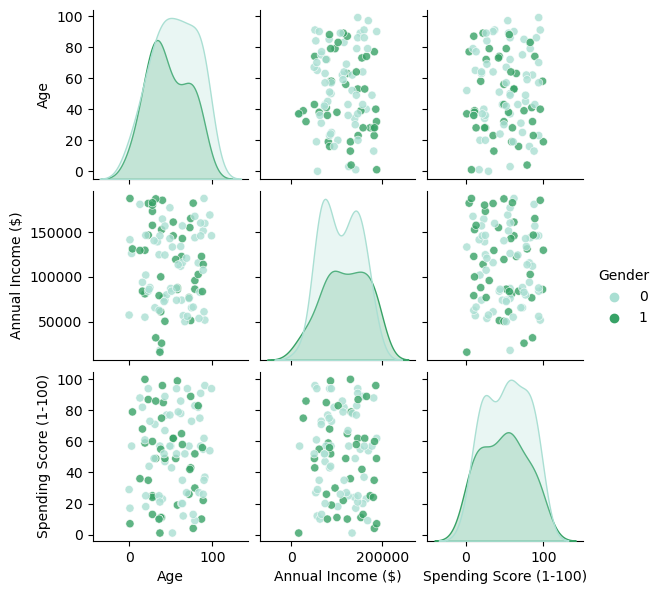

In [ ]:
sns.pairplot(sample100, x_vars = ["Age", "Annual Income ($)", "Spending Score (1-100)"], 
               y_vars = ["Age", "Annual Income ($)", "Spending Score (1-100)"], 
               hue = "Gender", 
               kind= "scatter",
               palette = "BuGn",
               height = 2,
               plot_kws={"s": 35, "alpha": 0.8});

### Stating X and y 

This will be used throughout the three models so I put it before I dove into the different models

In [ ]:
X = df.drop(['Spending Score (1-100)'], axis=1)
y = df['Spending Score (1-100)']

# Linear Regression 

Began with Linear Regression since it was the simplest ML model for predicting a Supervised Continous Variable.

Looking at the .head() feature to find where the chosen feature variable (X = Annual Income ($)) is located.

In [ ]:
sample100.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Age_Bin
870,1,63,122658,65,2,6,2,4
1059,0,34,139009,24,0,0,4,1
1440,1,58,85908,99,0,5,4,4
1636,0,1,141307,17,5,1,3,0
68,1,19,81000,59,0,0,4,0


The code below is the general formatting used for each model. X is the input variable which was assigned to the Annual Income feature and y is the target variable which was assigned the Spending Score variable. 

The train_test_split is a Scikit-learn function that splits the data into training and testing the model. Specifically:

X_train refers to the training input data
X_test refers to the testing input data
y_train refers to the training target data
y_test  refers to the testing target data

The test_size parameter is set to 0.4, signifying that 40% of the data will be used for testing the model and the remaining 60% will be used for training the model.

The random_state parameter is set to 44 (a random chosen number), which means that the randomization used to split the data will be the same each time the code is run.



In [ ]:
X = df.iloc[:, 2:3].values
y = df.iloc[:, 3].values

In [ ]:
X.shape

(2000, 1)

In [ ]:
def train_and_eval(model, X, y):
    print('\nResults from algorithm {}:'.format(model))

#     X = sample100.iloc[:, 2:3].values #Annual Income ($)
#     y = sample100.iloc[:, 3].values #Spending Score (1-100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=44)

    regr = linear_model.LinearRegression()
    model = regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("R2 Score: {:.2f}".format(r2))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))

    plt.scatter(X_test, y_test, color="darkseagreen")
    plt.plot(X_test, y_pred, color="sandybrown", linewidth=3)
    plt.title('Linear Regression Model')
    plt.xlabel('Annual Income ($)')
    plt.ylabel('Spending Score (1-100)')

    plt.show()
    return model


Results from algorithm LinearRegression():
Mean Squared Error: 787.68
R2 Score: -0.01
Mean cross-validation RMSE is 27.926 with SD 17.544


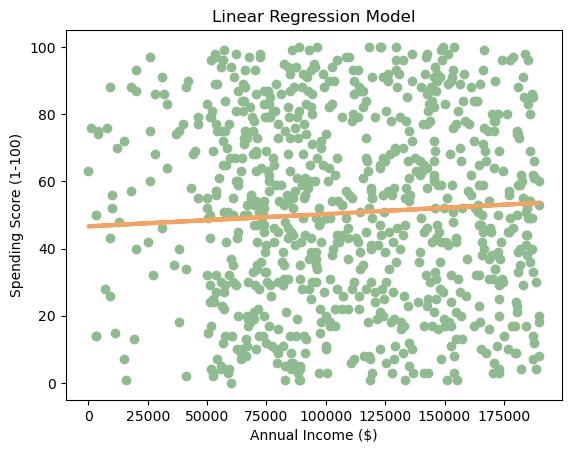

In [ ]:
from sklearn.linear_model import LinearRegression
regr = linear_model.LinearRegression()
_ = train_and_eval(regr, X, y)

This model poorly predicted that as salaries increased, so would the spending score. This was the one feature I was certain would have some sort of visable increment, however, that is not the case here. This led me to believe that the test data was overfitted so I decided to move forward with Random Forest and SVR for that reason.

# Support Vector Regression 

In [ ]:
X = sample100.drop(['Spending Score (1-100)'],axis=1)
y = sample100['Spending Score (1-100)']

In [ ]:
sample100.shape

(100, 8)

In [ ]:
X.shape

(100, 7)

In [ ]:
y.shape

(100,)

In [ ]:
def train_and_evalSVR(model, X, y):
    print('\nResults from algorithm {}:'.format(model))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=44)
    
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model = svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("R2 Score: {:.2f}".format(r2))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    
#     plt.scatter(X_test[:, 0], y_test, color='darkseagreen', label='Actual')
#     plt.scatter(X_test[:, 0], y_pred, color='peru', label='Predicted')
#     plt.xlabel('Annual Income ($)')
#     plt.ylabel('Spending Score')
#     plt.title(f'Support Vector Regression')
#     plt.show()
    
    plt.plot(X, y, color='darkseagreen', label='Actual')
    plt.plot(X_test, y_test, color='peru', label='Predicted SVR Model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()

    
    return model


Results from algorithm SVR(C=100, gamma=0.1):
Mean Squared Error: 684.29
R2 Score: -0.04
Mean cross-validation RMSE is 30.384 with SD 243.217


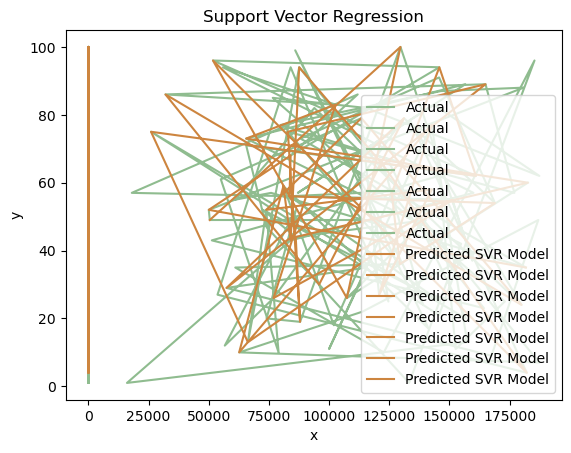

In [ ]:
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
_ = train_and_evalSVR(svr_model, X, y)

In [ ]:
from sklearn.tree import plot_tree

tree = rf_model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, filled=True)
plt.show()

NameError: name 'rf_model' is not defined

# Random Forest Regression

## Random Forest Regression Model

In [ ]:
X = df.iloc[:, 2:3].values
y = df.iloc[:, 3].values

In [ ]:
def train_and_evalRFR(model, X, y):
    print('\nResults from algorithm {}:'.format(model))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=44)

    rf_reg = RandomForestRegressor(n_estimators=10, random_state=44) 
    #I set the n_estimators to 10 to locate the 10 trees in the forest regression model
    model = rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("R2 Score: {:.2f}".format(r2))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    
    return model

In [ ]:
RFR_model = RandomForestRegressor()
_ = train_and_evalRFR(RFR_model, X, y)

### !!! The original scatter plot using the model from above was too crowded so...

The same model was utilized for the scatter plot but the X and y values were taken from the sample of 100 (sample100) rather than 2000 (df) from the original dataset.

However, to keep the evaluation scores consistent, the evaluation scores were removed from visibility and the scatter plot was added. 

SO keep in mind that this may not reflect a true visualisation of the model just a sample of the original model. 

In [ ]:
X = sample100.iloc[:, 2:3].values
y = sample100.iloc[:, 3].values

In [ ]:
def train_and_evalRFR(model, X, y):
    print('\nResults from algorithm using sample of 100 {}:'.format(model))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=44)

    rf_reg = RandomForestRegressor(n_estimators=10, random_state=44)
    model = rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))
    
    X_grid = np.arange(min(X), max(X), 0.01)
    X_grid = X_grid.reshape((len(X_grid), 1))
    
    plt.scatter(X, y, color = 'goldenrod')
    plt.plot(X_grid, rf_reg.predict(X_grid), color = 'darkgoldenrod')
    plt.title('Random Forest Regression Model')
    plt.xlabel('Annual Income ($)')
    plt.ylabel('Spending Score (1-100)')
    plt.show()
    
    
    return model

In [ ]:
RFR_model = RandomForestRegressor()
_ = train_and_evalRFR(RFR_model, X, y)

# Hyperparameters Using Cross-Validation

In [ ]:
def train_model(algorithm, hyperparams, X, y):
    model = algorithm(**hyperparams)
    scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    learnt_model = model.fit(X, y)
    return (np.mean(rmse_scores), learnt_model)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=44)

reg_values = np.arange(0.1, 1.3, 0.1)
reg_rmse = []
for reg_strength in reg_values:
    rmse, _ = train_model(SVR, {'C': reg_strength}, X_train, y_train)
    reg_rmse.append(rmse)

plt.plot(reg_values, reg_rmse, color='wheat')
plt.ylabel('RMSE on training data')
plt.xlabel('Value of regularization hyperparameter')
plt.show()

### SVR Scatter Plot with Hyperparameter Optimisation

In [ ]:
X = df.iloc[:, 2:3].values
y = df.iloc[:, 3].values

In [ ]:
train_accuracy, best_model = train_model(SVR, {'C': 0.8}, X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.44, random_state=44)


y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test data metrics:\nMean Squared Error: {:.2f}".format(mse))
print("R2 Score: {:.2f}".format(r2))
print("RMSE : {:.3f}".format(rmse))

plt.scatter(X_test, y_test, color="lightpink")
plt.plot(X_test, y_pred, color="coral", linewidth=3)
plt.title('SVR')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')

plt.show()